# **Setup installations**

In [ ]:
pip install pydub ffmpeg moviepy num2words matplotlib

# **Google Drive Usage --> Just load your RAW dataset in your drive.**


In [ ]:
from google.colab import drive
drive.mount('drive')

# **Value Definitions**

In [ ]:
author = input('Add the author name which is talking in the audios (i.e ciro_sannino): ') #'carlo_sansone'
language = input('Enter the language (2 characters, i.e "it") used in the audio / video: ') #'it'

Add the author name which is talking in the audios (i.e ciro_sannino): carlo_sansone
Enter the language (2 characters, i.e "it") used in the audio / video: it


# **Set the row dataset path and where we have to save your new dataset**

In [ ]:
# https://drive.google.com/drive/folders/1bYPnqfjuvoqgaknqbwTFhW_ULHOQifkP?usp=sharing 
# sansone raw dataset
raw_dataset_url = '/content/drive/My Drive/sansone_dataset/' # get your raw dataset link from drive and paste it here
output_dataset_path = '/content/drive/My Drive/output_dataset/' # set where we should save the new dataset

# **Creating the directories**

In [ ]:
author_path =  output_dataset_path + author
wavs_path = output_dataset_path + author + '/wavs/'
!mkdir '$output_dataset_path'
!mkdir '$author_path'
!mkdir '$wavs_path'

mkdir: cannot create directory ‘/content/drive/My Drive/output_dataset/’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/output_dataset/carlo_sansone’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/output_dataset/carlo_sansone/wavs/’: File exists


# **Class Definitions**

In [ ]:
import re
from pydub import AudioSegment

class SentenceAudioObject:
  author = ''
  lesson = ''
  index = 0
  sentence = ""
  startTime = 0
  endTime = 0

  def __init__(self, author, lesson, index, sentence, startTime, endTime):
        self.author = author
        self.lesson = lesson
        self.index = index
        self.sentence = sentence
        self.startTime = startTime
        self.endTime = endTime
  
  def writeAudioSentence(self, destination):
        t1 = float(self.startTime) * 1000
        t2 = float(self.endTime) * 1000
        newAudio = AudioSegment.from_wav('audio.wav',)
        newAudio = newAudio[t1:t2]
        newAudio = newAudio.set_frame_rate(22050)
        newAudio = newAudio.set_channels(1)
        return newAudio.export(destination + self.getAudioTitle() + '.wav', format="wav")
  
  def getAudioTitle(self):
    return self.lesson + "_" + str(self.index)

  def duration(self):
    return (float(self.endTime) - float(self.startTime))

  def debugPrint(self):
      print("Sentence: " + self.sentence + "\n" 
            + "start time: " + self.startTime + "\n"
            + "end time: " + self.endTime)


In [ ]:
import moviepy.editor as mp
import subprocess

def extractAudio(videoName):
    subprocess.run( #converts the webm to wav using ffmpeg
        (['ffmpeg', '-y', '-i', videoName, 'audio.wav']))

In [ ]:
import num2words
from datetime import datetime

def is_number(s): # determines if input is a number or not
    if s.lower() == 'nan':
      return False
    else:
      try:
        float(s)
        return True
      except ValueError:
        return False
    

def textnum2str(text, language): # converts a sentence containing numbers to a sentence with those numbers converted to strings
    strarr = text.split()
    for i in range(len(strarr)):
        if is_number(strarr[i]):
            strarr[i] = num2words.num2words(float(strarr[i]), lang=language)
    formatted = ""
    for str in strarr:
        formatted = formatted + str + " "
    return formatted

def timeStringToSeconds(timeString):
  date_time = datetime.strptime(timeString.rstrip().lstrip(), "%H:%M:%S,%f")
  a_timedelta = date_time - datetime(1900, 1, 1)
  seconds = a_timedelta.total_seconds()
  return seconds

def getSentenceObjects(filename, lesson_name, starting_count):
    file = open( filename, "r")
    lines = file.readlines()
    file.close()

    non_empty_lines = [line for line in lines if line.rstrip().lstrip() != ""]
    tmpArraySentenceObj = []
    arrayOfFinalSentencesObject = []

    count = starting_count
    for (index,line) in enumerate(non_empty_lines):

      if (line.strip().isdecimal() and index != len(non_empty_lines)-1):
        firstSentence = non_empty_lines[index+2].strip()
        secondSentence = ''
        if index + 3 < len(non_empty_lines) and non_empty_lines[index+3].strip().isdecimal() == False:
          secondSentence = non_empty_lines[index+3].strip()
        times = (non_empty_lines[index+1].strip()).split('-->')
        startTime = str(timeStringToSeconds(times[0]))
        endTime = str(timeStringToSeconds(times[1]))
        tmp_obj = SentenceAudioObject(author, lesson_name, index, firstSentence.strip() + " " + secondSentence.strip(), startTime, endTime)
        tmpArraySentenceObj.append(tmp_obj)

        if ((secondSentence.rstrip().endswith('.') or secondSentence.rstrip().endswith('?')) or (secondSentence == '' and (firstSentence.rstrip().endswith('.') or firstSentence.rstrip().endswith('?')))):
          final_sentence = ' '.join([x.sentence for x in tmpArraySentenceObj])
          final_obj = SentenceAudioObject(author, lesson_name, count, final_sentence, tmpArraySentenceObj[0].startTime, tmpArraySentenceObj[len(tmpArraySentenceObj) - 1].endTime)
          count += 1
          tmpArraySentenceObj = []
          arrayOfFinalSentencesObject.append(final_obj)

    return arrayOfFinalSentencesObject


# **Defining the function that will produce our SpeechDataset**

In [ ]:
import os

def produceSpeechDataset(raw_dataset_url, author_path): # an output folder called 'wavs' and a 'metadata.csv' file will be generated
  f = open(author_path + "/filelists" + ".txt", "w", encoding="utf-8")
  objects = []
  for root, subdirectories, files in os.walk(raw_dataset_url):
    for subdirectory in subdirectories:
      wavs_count = 0
      #initialize variables
      subtitle_objects = []
      print('\n Processing ' + subdirectory + ' directory...')
      for filename in os.listdir(raw_dataset_url + subdirectory):
        # get the mp4 and get its audio as .wav file. Saving this audio as 'audio.wav'
        if filename.lower().endswith('.mp4'):
          extractAudio(root+subdirectory+ '/'+filename)
        # get the .srt file and getting the SentenceObjects.
        if filename.lower().endswith('.srt'):
          subtitle_objects = getSentenceObjects(root+subdirectory+'/'+filename, subdirectory, wavs_count)
          wavs_count += (len(subtitle_objects)-1)
      # for each subtitle_object generated we cut the extracted audio in the interval (startTime-->EndTime) 
      # and write the output audio in the wavs_path. Adding also the informations of the output audio in the .csv file
      for obj in subtitle_objects:
        filename = obj.getAudioTitle()
        ext = '.wav'
        sentence = obj.sentence
        formattedSentence = textnum2str(sentence, language)
        f.write('wavs/' + filename + ext + '|' + formattedSentence + '\n')
        obj.writeAudioSentence(wavs_path)
      objects += subtitle_objects
  os.remove('audio.wav')
  f.close()
  return objects


In [ ]:
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt

def createHistogram(objects): # input will be an array of SentenceObjects
  durations = list(object.duration() for object in objects)
  # formula to calculate the bins
  bins = 20
  #int((np.max(durations) - np.min(durations))/sqrt(len(durations)))
  plt.hist(durations, bins = bins)
  plt.show()

# **Output generations**

In [ ]:
objects = produceSpeechDataset(raw_dataset_url, author_path)

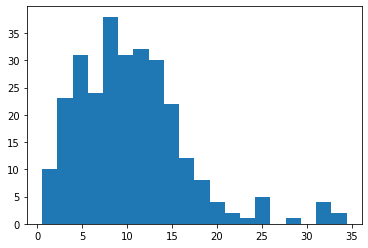

In [ ]:
createHistogram(objects)